Paso 1: Recopilación de Datos

Asegúrate de tener acceso a datos históricos de precipitación que incluyan fechas y ubicaciones geográficas específicas. Puedes utilizar el archivo CSV que mencionaste anteriormente, "PREC_1981_2010_Provincias.csv".
Paso 2: Preprocesamiento de Datos

Carga los datos del archivo CSV en un DataFrame de pandas.
Limpia y preprocesa los datos, manejando valores faltantes y convirtiendo las fechas en un formato adecuado.
Puedes calcular métricas adicionales, como el promedio de precipitación por año o estación del año, si es relevante para tu modelo.
Paso 3: Definición de Sequías e Inundaciones

Define criterios para clasificar lo que consideras sequías e inundaciones. Por ejemplo, podrías considerar sequía cuando la precipitación anual sea significativamente inferior al promedio, e inundación cuando supere el promedio.
Paso 4: Ingeniería de Características

Crea características adicionales que puedan ser relevantes para el modelo, como la duración de períodos secos o húmedos.
Paso 5: División de Datos

Divide los datos en un conjunto de entrenamiento y un conjunto de prueba. Esto te permitirá evaluar el rendimiento del modelo de manera adecuada.
Paso 6: Modelado

Selecciona un modelo adecuado para la predicción de sequías e inundaciones. Podrías comenzar con un modelo de regresión logística o un modelo de clasificación, como Random Forest o SVM.
Entrena el modelo utilizando el conjunto de entrenamiento.
Paso 7: Evaluación del Modelo

Evalúa el modelo utilizando el conjunto de prueba y métricas de rendimiento, como precisión, recall, F1-score y matriz de confusión.
Realiza ajustes en el modelo según sea necesario para mejorar su rendimiento.
Paso 8: Predicciones Futuras

Utiliza el modelo entrenado para realizar predicciones sobre datos futuros de precipitación. Esto te permitirá predecir la posibilidad de sequías o inundaciones en función de datos actuales y futuros.
Paso 9: Visualización de Resultados

Visualiza las predicciones y resultados de manera efectiva. Puedes utilizar gráficos de series temporales y mapas para mostrar las áreas afectadas.
Paso 10: Despliegue y Monitoreo

Implementa el modelo en una aplicación o plataforma que sea accesible para las autoridades locales y agricultores.
Establece un sistema de monitoreo continuo para que el modelo pueda actualizarse con nuevos datos y seguir siendo preciso.
Este es un proyecto complejo que requerirá tiempo y esfuerzo, pero puede proporcionar información valiosa para la toma de decisiones en situaciones climáticas extremas. A medida que avances en cada paso, puedes encontrar oportunidades para refinar y mejorar tu modelo. Además, ten en cuenta que la calidad de los datos históricos de precipitación es fundamental para la precisión del modelo, por lo que asegúrate de tener datos confiables y actualizados.

In [19]:
import pandas as pd

#EN ESTE CODIGO MODIFICO UNOS DATOS QUE ENCONTRÉ EN INTERNET

# Cargar el archivo CSV
df_norte = pd.read_csv('nordics_weather.csv')

# Eliminar las columnas innecesarias
df_norte = df_norte.drop(columns=['snow_depth', 'tavg', 'tmax', 'tmin'])

# Convertir la columna 'date' a tipo de dato fecha
df_norte['date'] = pd.to_datetime(df_norte['date'])

# Crear columnas separadas para año y mes
df_norte['ano'] = df_norte['date'].dt.year
df_norte['mes'] = df_norte['date'].dt.month

# Sumar la precipitación diaria para obtener la precipitación mensual
df_mensual = df_norte.groupby(['country', 'ano', 'mes']).agg({'precipitation': 'sum'}).reset_index()

# Pivotear el DataFrame para tener columnas separadas para cada mes
df_mensual = df_mensual.pivot_table(index=['country', 'ano'], columns='mes', values='precipitation', fill_value=0).reset_index()

# Cambiar el nombre de la columna 'country' a 'region' para que coincida con tus otros conjuntos de datos
df_mensual.rename(columns={'country': 'region'}, inplace=True)

# Agregar una columna 'Parametro' con el valor 'Precipitacion'
df_mensual['Parametro'] = 'Precipitacion'

# Calcular la columna 'anual' como la suma de las precipitaciones mensuales
df_mensual['anual'] = df_mensual[list(range(1, 13))].sum(axis=1)

# Cambiar los nombres de las columnas 1 a 12 por los nombres de los meses
meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
df_mensual.rename(columns=dict(zip(range(1, 13), meses)), inplace=True)

# Reorganizar el orden de las columnas
column_order = ['Parametro', 'region'] + meses + ['anual']

df_mensual = df_mensual[column_order]

# Guardar el DataFrame resultante en un archivo CSV si es necesario
df_mensual.to_csv('nordics_weather_transformed.csv', index=False)





In [20]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import joblib

# Cargar el modelo entrenado en el primer archivo (proyecto_lluvia)
modelo_regresion = joblib.load('modelo_lluvia')  # Asegúrate de que el nombre del archivo sea correcto

# Cargar los datos desde los archivos CSV de 2019, 2020 y 2021
df_1981 = pd.read_csv('PREC_1981_2010_Provincias.csv', delimiter=';')
df_2019 = pd.read_csv('PREC_2019_Provincias.csv', delimiter=';')
df_2020 = pd.read_csv('PREC_2020_Provincias.csv', delimiter=';')
df_2021 = pd.read_csv('PREC_2021_Provincias.csv', delimiter=';')
df_2022 = pd.read_csv('PREC_2022_Provincias.csv', delimiter=';')
df_paises_del_norte = pd.read_csv('nordics_weather_transformed.csv', delimiter=',')

# Crea df inicial si aún no está definido
if 'df' not in locals():
    df = pd.DataFrame()
# Llenar los valores nulos con la media de la columna
df.fillna(df.mean(), inplace=True)

# Combinar los nuevos datos con los datos existentes
df = pd.concat([df, df_2019, df_2020, df_2021,df_1981,df_2022,df_paises_del_norte], ignore_index=True)

# Predecir el valor anual de lluvia usando el modelo de regresión lineal
df['anual_predicho'] = modelo_regresion.predict(df[['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']])

# Ajustar umbrales manuales para determinar el estado climático
umbral_sequia = 400.0 # Establecer un valor bajo para la sequía
umbral_inundacion = 1000.0  # Establecer un valor alto para la inundación

# Crear una columna "estado_climatico" basada en los nuevos umbrales usando if
df['estado_climatico'] = 'Normal'  # Inicializar con 'Normal'
df.loc[df['anual_predicho'] < umbral_sequia, 'estado_climatico'] = 'Sequía'
df.loc[df['anual_predicho'] > umbral_inundacion, 'estado_climatico'] = 'Inundación'


# Dividir los datos en características (X) y etiquetas (y)
X = df[['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']]
y = df['estado_climatico']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y ajustar un modelo de regresión logística
modelo_clasificacion = LogisticRegression(random_state=42)
modelo_clasificacion.fit(X_train, y_train)



# Realizar predicciones en el conjunto de prueba
y_pred = modelo_clasificacion.predict(X_test)

# Evaluar el rendimiento del modelo
reporte_clasificacion = classification_report(y_test, y_pred)
print(reporte_clasificacion)


              precision    recall  f1-score   support

  Inundación       0.90      0.82      0.86        11
      Normal       0.83      0.95      0.88        76
      Sequía       0.81      0.50      0.62        26

    accuracy                           0.83       113
   macro avg       0.85      0.76      0.79       113
weighted avg       0.83      0.83      0.82       113



C:\Users\sgcov\AppData\Local\Temp\ipykernel_1212\2755159130.py:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace=True)
C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


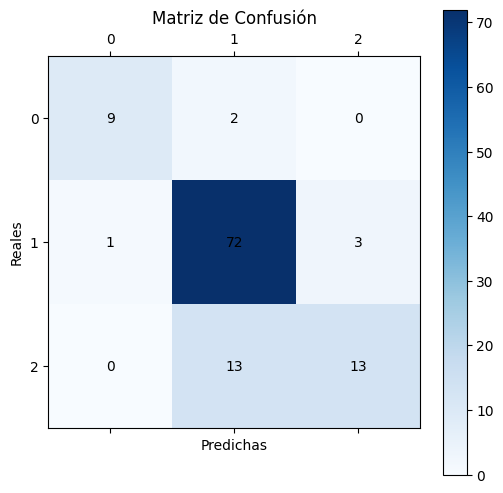

Accuracy: 0.831858407079646
Precision: 0.8311641745498931
Recall: 0.831858407079646
F1-score: 0.8200434851175934


In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def visualiza_metricas(y_reales, y_predichas, titulo):
    matriz_confusion = confusion_matrix(y_reales, y_predichas)
    accuracy = accuracy_score(y_reales, y_predichas)
    precision = precision_score(y_reales, y_predichas, average='weighted')
    recall = recall_score(y_reales, y_predichas, average='weighted')
    f1 = f1_score(y_reales, y_predichas, average='weighted')

    plt.figure(figsize=(6, 6))
    plt.matshow(matriz_confusion, cmap="Blues", fignum=1)
    plt.title("Matriz de Confusión")
    plt.xlabel("Predichas")
    plt.ylabel("Reales")
    plt.colorbar()

    for i in range(matriz_confusion.shape[0]):
        for j in range(matriz_confusion.shape[1]):
            plt.text(j, i, str(matriz_confusion[i, j]), va='center', ha='center')

    plt.show()

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

# Realizar predicciones en el conjunto de prueba
y_pred_clases = modelo_clasificacion.predict(X_test)

# Visualizar las métricas y la matriz de confusión
visualiza_metricas(y_test, y_pred, "Métricas de Clasificación")



In [22]:
import numpy as np

# Crear un vector de características para la predicción
nuevo_dato = np.array([13.4, 57.9, 13.9, 28.4, 18.6, 11.1, 2.0, 6.1, 6.8, 15.6, 3.6, 11.5]).reshape(1, -1)

# Crear un vector de características para la predicción
nuevo_dato2 = np.array([191.0, 148.9, 128.4, 139.1, 117.5, 58.9, 36.0, 43.5, 93.8, 212.0, 217.2, 241.0]).reshape(1, -1)

# Crear un vector de características para la predicción
nuevo_dato3 = np.array([31.2, 45.5, 34.8, 20.9, 10.3, 2.7, 23.1, 8.9, 7.6, 5.8, 1.4, 10.2]).reshape(1, -1)

bergen = np.array([190.0, 152.0, 170.0, 114.0, 106.0, 132.0, 148.0, 190.0, 283.0, 271.0, 259.0, 235.0]).reshape(1, -1)

lista_datos = [nuevo_dato, nuevo_dato2, nuevo_dato3, bergen]

for datos in lista_datos:
    # Realizar la predicción usando el modelo de clasificación
    resultado_clasificacion = modelo_clasificacion.predict(datos)
    
    # Traducir el resultado de clasificación en una etiqueta legible
    if resultado_clasificacion[0] == 'Normal':
        condicion_climatica = 'Condiciones Normales'
    elif resultado_clasificacion[0] == 'Inundación':
        condicion_climatica = 'Posible Inundación'
    else:
        condicion_climatica = 'Sequía'
    
    print(f"Predicción de Condiciones Climáticas (Clasificación): {condicion_climatica}")
    
   

# Realizar la predicción usando el modelo de regresión
resultado_regresion = modelo_regresion.predict(bergen)
    
# Imprimir el resultado de regresión
print(f"Predicción de Valor Anual de Lluvia (Regresión): {round(resultado_regresion[0],1)}")

Predicción de Condiciones Climáticas (Clasificación): Condiciones Normales
Predicción de Condiciones Climáticas (Clasificación): Posible Inundación
Predicción de Condiciones Climáticas (Clasificación): Condiciones Normales
Predicción de Condiciones Climáticas (Clasificación): Posible Inundación
Predicción de Valor Anual de Lluvia (Regresión): 2250.0


C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Importa las bibliotecas necesarias: pandas para el manejo de datos, numpy para cálculos numéricos y matplotlib.pyplot para crear gráficos.

Crea un DataFrame llamado df que contiene dos columnas: 'mes' y 'precipitacion'. Estos datos son de ejemplo y representan la precipitación mensual en mm para cada mes del año.

Define un diccionario llamado meses que mapea el nombre de los meses a sus valores numéricos correspondientes.

Crea una nueva columna en el DataFrame llamada 'mes_num' que asigna valores numéricos a los meses utilizando el mapeo definido en el paso anterior.

Calcula el promedio de precipitación por mes utilizando groupby y mean(). El resultado se almacena en la variable promedio_por_mes, que es una serie de pandas.

Encuentra el mes más lluvioso y el menos lluvioso utilizando los métodos idxmax() y idxmin() en la serie promedio_por_mes.

Define umbrales para identificar sequía y lluvia excepcional. En este caso, el umbral de sequía es de 50.0 mm y el umbral de lluvia excepcional es de 200.0 mm. Puedes ajustar estos valores según tus necesidades.

Crea una nueva columna en el DataFrame llamada 'estado' que identifica el estado del mes en función de los umbrales definidos. Si la precipitación es inferior al umbral de sequía, se etiqueta como 'Sequía'. Si la precipitación es superior al umbral de lluvia excepcional, se etiqueta como 'Lluvia Excepcional'. De lo contrario, se etiqueta como 'Normal'.

Imprime las estadísticas mensuales de precipitación, que muestran el promedio de precipitación para cada mes.

Imprime el mes más lluvioso y el menos lluvioso.

Crea un gráfico de barras que muestra la precipitación mensual. Los meses se etiquetan en el eje X, la precipitación en mm se representa en el eje Y, y los colores de las barras indican si el mes se encuentra en sequía (rojo), lluvia excepcional (azul) o normal (verde).

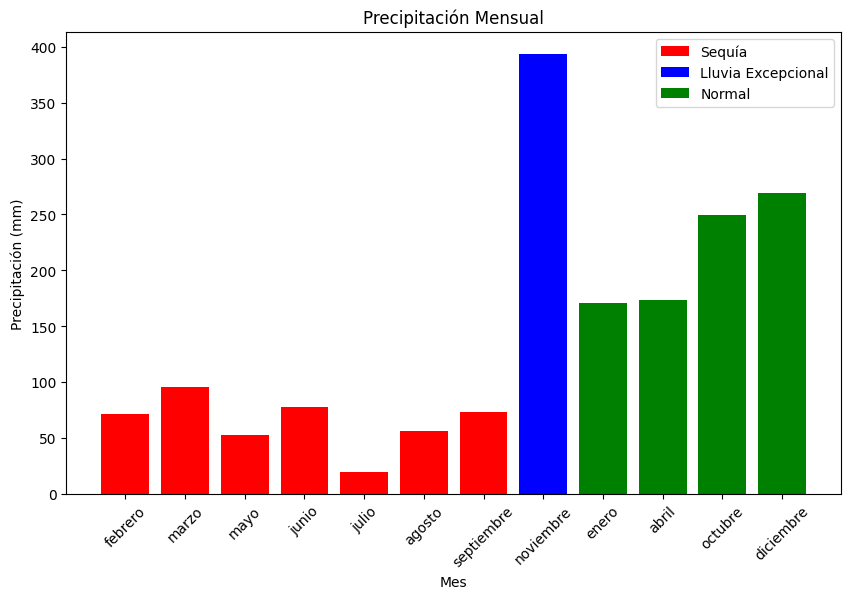

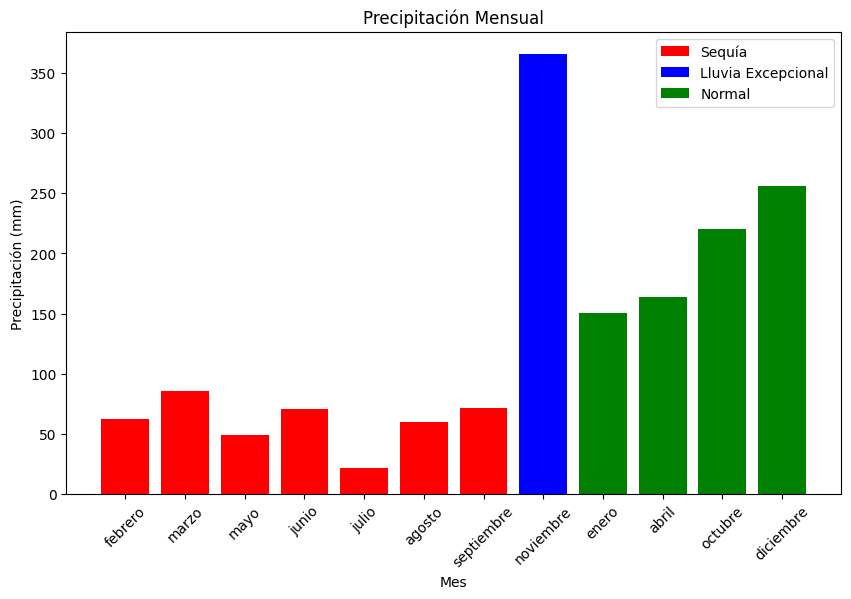

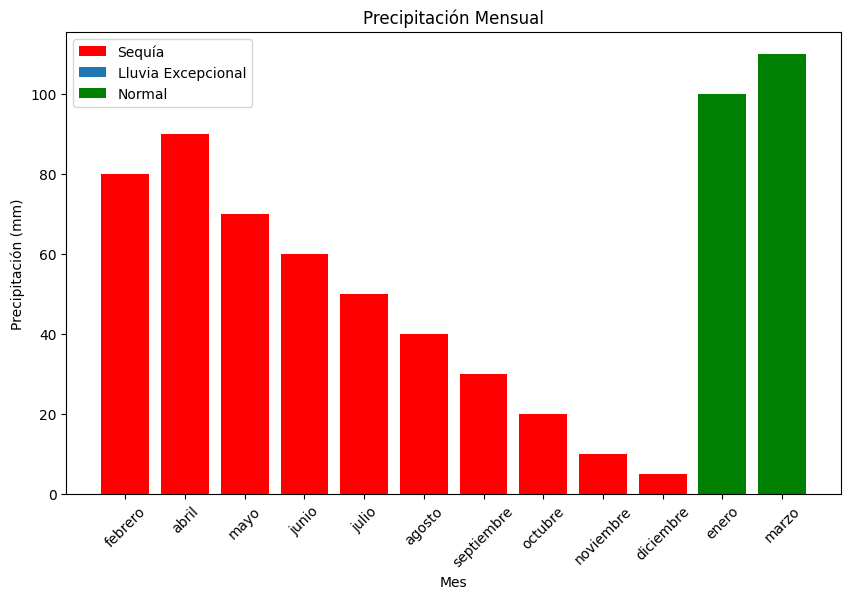

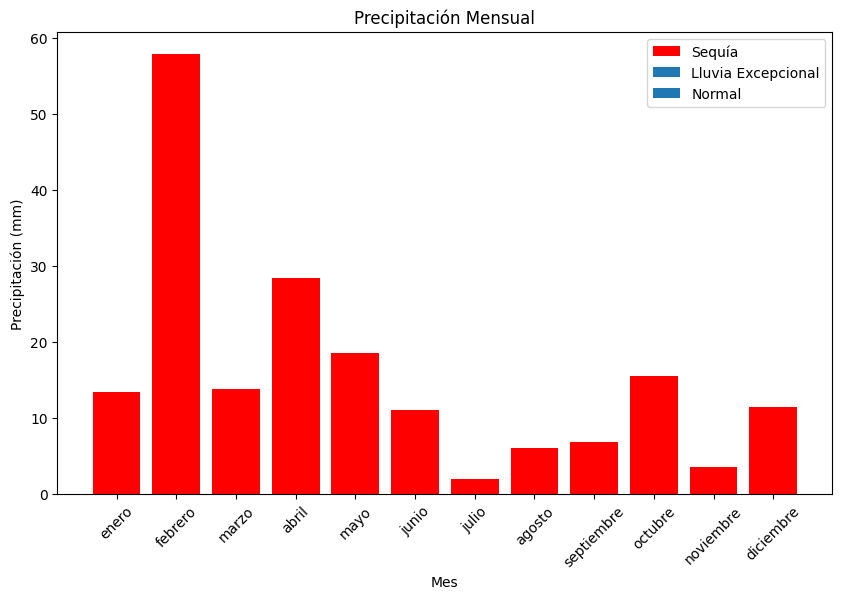

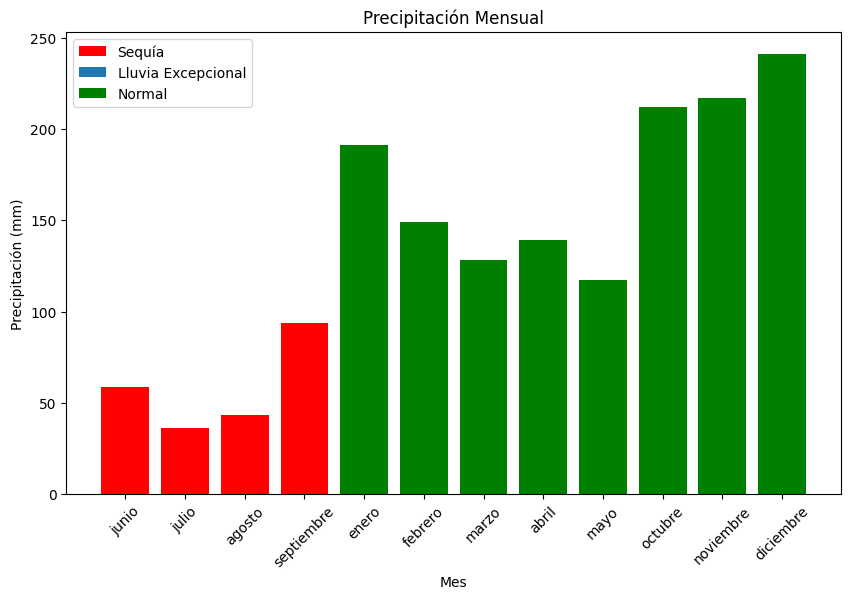

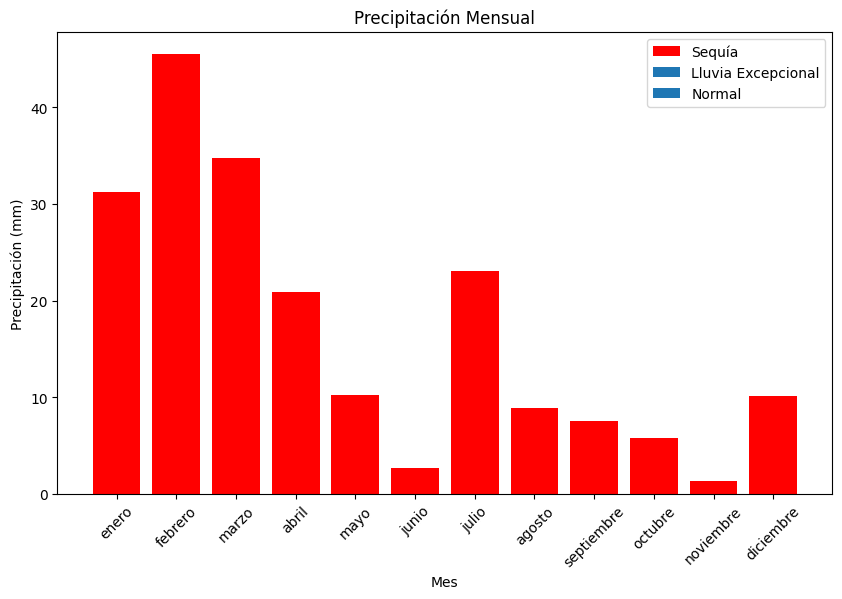

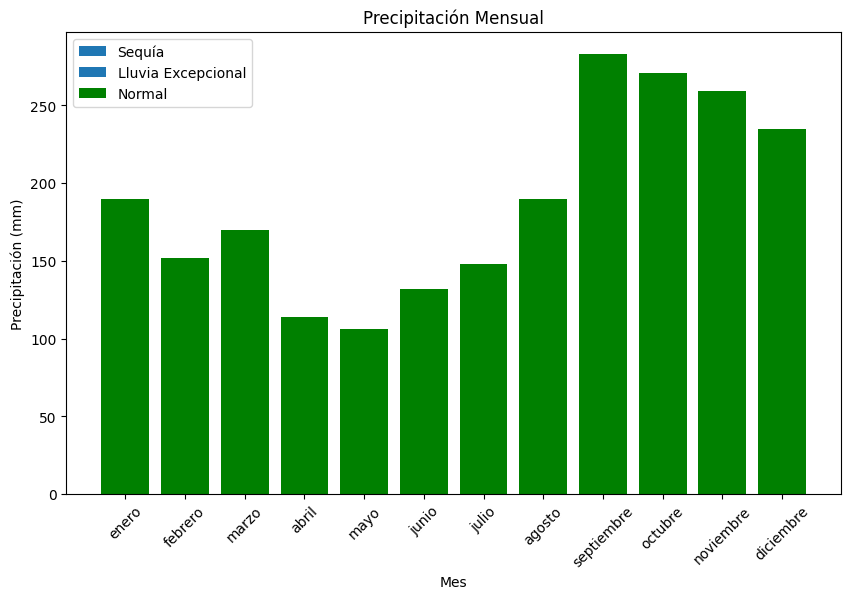

Resultados para el Dataset 1:
Promedio: 142.08333333333334
Mes más lluvioso: noviembre
Mes menos lluvioso: julio

Resultados para el Dataset 2:
Promedio: 131.275
Mes más lluvioso: noviembre
Mes menos lluvioso: julio

Resultados para el Dataset 3:
Promedio: 55.416666666666664
Mes más lluvioso: marzo
Mes menos lluvioso: diciembre

Resultados para el Dataset 4:
Promedio: 15.741666666666665
Mes más lluvioso: febrero
Mes menos lluvioso: julio

Resultados para el Dataset 5:
Promedio: 135.60833333333332
Mes más lluvioso: diciembre
Mes menos lluvioso: julio

Resultados para el Dataset 6:
Promedio: 16.866666666666667
Mes más lluvioso: febrero
Mes menos lluvioso: noviembre

Resultados para el Dataset 7:
Promedio: 187.5
Mes más lluvioso: septiembre
Mes menos lluvioso: mayo



In [23]:

import numpy as np
import matplotlib.pyplot as plt

def analizar_datos_lista(lista_dataframes, umbral_sequia=100.0, umbral_lluvia_excepcional=300.0):
    resultados_por_dataset = []

    for df in lista_dataframes:
        # Calcular estadísticas de precipitación
        promedio = df['precipitacion'].mean()
        mes_mas_lluvioso = df['mes'][df['precipitacion'].idxmax()]
        mes_menos_lluvioso = df['mes'][df['precipitacion'].idxmin()]

        # Identificar meses de sequía y lluvia excepcional
        df['estado'] = np.where(df['precipitacion'] < umbral_sequia, 'Sequía',
                                np.where(df['precipitacion'] > umbral_lluvia_excepcional, 'Lluvia Excepcional',
                                         'Normal'))

        # Crear un diccionario de colores para la leyenda
        colores = {'Sequía': 'red', 'Lluvia Excepcional': 'blue', 'Normal': 'green'}

        # Mostrar gráfico de precipitación por mes
        plt.figure(figsize=(10, 6))
        for estado, color in colores.items():
            plt.bar(df['mes'][df['estado'] == estado], df['precipitacion'][df['estado'] == estado], color=color, label=estado)

        plt.xlabel('Mes')
        plt.ylabel('Precipitación (mm)')
        plt.title('Precipitación Mensual')
        plt.xticks(rotation=45)

        # Agregar la leyenda
        plt.legend()

        plt.show()

        # Retornar resultados para este dataset
        resultados = {
            'promedio': promedio,
            'mes_mas_lluvioso': mes_mas_lluvioso,
            'mes_menos_lluvioso': mes_menos_lluvioso
        }
        resultados_por_dataset.append(resultados)

    # Retornar resultados para todos los datasets
    return resultados_por_dataset

# Ejemplo de cómo usar la función con una lista de DataFrames de datos
data1 = {
    'mes': ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre'],
    'precipitacion': [171.2, 72.0, 96.1, 173.7, 52.9, 78.2, 19.6, 56.6, 73.2, 249.4, 393.3, 268.8]
}

data2 = {
    'mes': ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre'],
    'precipitacion': [150.2, 62.5, 85.3, 163.8, 48.9, 70.4, 21.3, 60.0, 71.5, 220.1, 365.5, 255.8]
}

data3 = {
    'mes': ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre'],
    'precipitacion': [100.0, 80.0, 110.0, 90.0, 70.0, 60.0, 50.0, 40.0, 30.0, 20.0, 10.0, 5.0]
}

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)

# Crear una lista de DataFrames
lista_de_dataframes = [df1, df2, df3]

def convertir_df_a_np(dataframe):
    # Convierte el DataFrame a un arreglo NumPy y luego aplana en una sola fila
    arreglo_np = dataframe.to_numpy().flatten()
    return arreglo_np

#función para convertir los arrays a dataframe para la función analizar_datos_lista()
def convertir_np_a_data(np):
    lst = list(np[0])
    lst_float = [float(x) for x in lst]  # Convierte los elementos a float
    return {'mes': ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre'], 'precipitacion': lst_float}

for i in lista_datos:
    df = convertir_np_a_data(i)
    df = pd.DataFrame(df)  # Convierte el diccionario en DataFrame
    lista_de_dataframes.append(df)


resultados = analizar_datos_lista(lista_de_dataframes)

for i, resultado in enumerate(resultados, start=1):
    print(f"Resultados para el Dataset {i}:")
    print(f"Promedio: {resultado['promedio']}")
    print(f"Mes más lluvioso: {resultado['mes_mas_lluvioso']}")
    print(f"Mes menos lluvioso: {resultado['mes_menos_lluvioso']}\n")

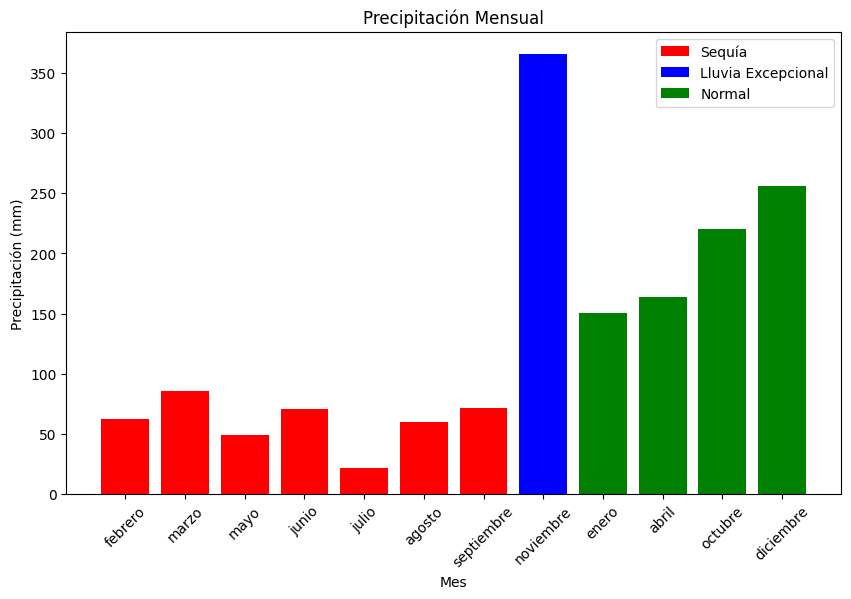

Resultados para la Ciudad cordoba:
Promedio: 131.275 mm
Mes más lluvioso: noviembre
Mes menos lluvioso: julio

[[150.2  62.5  85.3 163.8  48.9  70.4  21.3  60.   71.5 220.1 365.5 255.8]]
Predicción de Valor Anual de Lluvia (Regresión): [1575.3]
Predicción de Condiciones Climáticas (Clasificación): Posible Inundación


C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [24]:
#NOTA hay que meter toto esto en una funcion principal

# Cargar los datos desde el archivo CSV
archivo_csv = 'cordoba.csv'
df_prueba = pd.read_csv(archivo_csv)
nombre_archivo = archivo_csv.split('/')[-1]

# Eliminar la extensión '.csv' para obtener el nombre de la ciudad
ciudad = nombre_archivo.split('.')[0]


lista_prueba=[]
lista_prueba.append(df_prueba)
resultados_prueba = analizar_datos_lista(lista_prueba)

for resultado in resultados_prueba:
    print(f"Resultados para la Ciudad {ciudad}:")
    print(f"Promedio: {resultado['promedio']} mm")
    print(f"Mes más lluvioso: {resultado['mes_mas_lluvioso']}")
    print(f"Mes menos lluvioso: {resultado['mes_menos_lluvioso']}\n"
   )


    
    
#_____________________________________________________modelo_regresion

# Convierte el DataFrame en un arreglo NumPy
datos_prueba = df_prueba['precipitacion'].values.reshape(1, -1)

#datos_prueba = convertir_df_a_np(df_prueba).reshape(1, -1)
print(datos_prueba)
# Realizar la predicción usando el modelo de regresión
resultado_regresion = modelo_regresion.predict(datos_prueba)

# Imprimir el resultado de regresión
print(f"Predicción de Valor Anual de Lluvia (Regresión): {resultado_regresion}")
#____________________________________modelo_clasificacion    
lista_datos2 = []
lista_datos2.append(datos_prueba)
for datos in lista_datos2:
    # Realizar la predicción usando el modelo de clasificación
    resultado_clasificacion = modelo_clasificacion.predict(datos)
    
    # Traducir el resultado de clasificación en una etiqueta legible
    if resultado_clasificacion[0] == 'Normal':
        condicion_climatica = 'Condiciones Normales'
    elif resultado_clasificacion[0] == 'Inundación':
        condicion_climatica = 'Posible Inundación'
    else:
        condicion_climatica = 'Sequía'
    
    print(f"Predicción de Condiciones Climáticas (Clasificación): {condicion_climatica}")    
    



Introduce nombre de la ciudad: Jerez


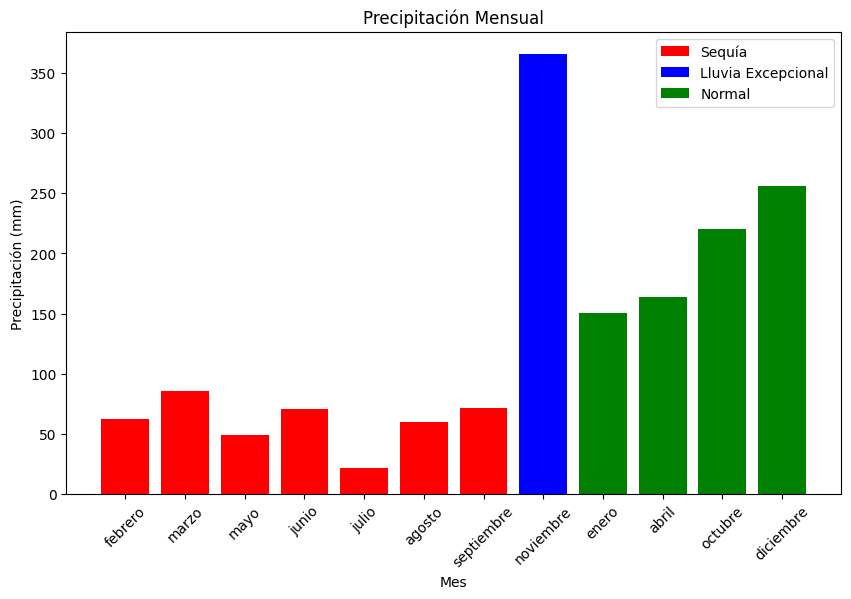

Resultados para la Ciudad Jerez:
Promedio: 131.275 mm
Mes más lluvioso: noviembre
Mes menos lluvioso: julio

Predicción de Condiciones Climáticas: Posible Inundación por el mes de noviembre


C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [25]:
ciudad = input('Introduce nombre de la ciudad: ')

# Crear un DataFrame a partir de los datos del cliente
datos_cliente = pd.DataFrame({
    'mes': ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre'],
    'precipitacion': [150.2, 62.5, 85.3, 163.8, 48.9, 70.4, 21.3, 60.0, 71.5, 220.1, 365.5, 255.8]
})
'''# Cargar los datos desde el archivo CSV en la variable np
np = pd.read_csv('Jerez.csv')
datos_cliente=convertir_np_a_data(np)
print(datos_cliente)'''
# Crear una lista de DataFrames que incluye el DataFrame del cliente
lista_datos = [datos_cliente]

resultados2 = analizar_datos_lista(lista_datos)

for resultado in resultados2:
    print(f"Resultados para la Ciudad {ciudad}:")
    print(f"Promedio: {resultado['promedio']} mm")
    print(f"Mes más lluvioso: {resultado['mes_mas_lluvioso']}")
    print(f"Mes menos lluvioso: {resultado['mes_menos_lluvioso']}\n"
   )
    
#____________________________________modelo_clasificacion    
# Convierte el DataFrame en un arreglo NumPy
datos_prueba2 = datos_cliente['precipitacion'].values.reshape(1, -1)
lista_datos2 = []
lista_datos2.append(datos_prueba2)
for datos in lista_datos2:
    # Realizar la predicción usando el modelo de clasificación
    resultado_clasificacion = modelo_clasificacion.predict(datos)
    
    # Traducir el resultado de clasificación en una etiqueta legible
    if resultado_clasificacion[0] == 'Normal':
        condicion_climatica = 'Condiciones Normales'
    elif resultado_clasificacion[0] == 'Inundación':
        condicion_climatica = 'Posible Inundación'
    else:
        condicion_climatica = 'Sequía' 
    print(f"Predicción de Condiciones Climáticas: {condicion_climatica} por el mes de {resultado['mes_mas_lluvioso']}")   

In [65]:
import numpy as np
import joblib

# Define umbrales para cada grupo de ciudades
umbrales_sequia = [100, 70, 40, 20, 0]
umbrales_inundacion = [200, 250, 300, 350, 400]

# Diccionario con las ciudades por provincia y su grupo correspondiente
ciudades_por_provincia = {
    1: ['jaen', 'cordoba', 'sevilla', 'malaga', 'almeria'],
    2: ['granada'],
    3: ['valencia', 'murcia', 'alicante'],
    4: ['zaragoza', 'teruel', 'huesca'],
    5: ['segovia', 'avila', 'soria'],
    6: ['toledo', 'cuenca', 'guadalajara'],
    7: ['ciudad_real', 'badajoz', 'caceres'],
    8: ['huelva', 'cadiz', 'jaen'],
    9: ['valladolid', 'burgos', 'leon', 'palencia', 'soria', 'segovia', 'avila', 'salamanca', 'zamora'],
    10: ['vizcaya', 'gipuzkoa', 'bizkaia'],
    11: ['cantabria'],
    12: ['asturias'],
    13: ['la_rioja'],
    14: ['albacete', 'ciudad_real', 'cuenca', 'guadalajara', 'toledo'],
    15: ['lleida', 'tarragona', 'girona'],
    16: ['lleida', 'tarragona', 'girona', 'castellon', 'valencia'],
    17: ['lleida', 'tarragona', 'girona', 'castellon'],
    18: ['las_palmas', 'santa_cruz_de_tenerife'],
    19: ['cantabria', 'navarra', 'huesca', 'zaragoza', 'teruel', 'la_rioja'],
    20: ['alava', 'navarra', 'gipuzkoa', 'bizkaia'],
    21: ['murcia', 'albacete'],
    22: ['lleida', 'tarragona', 'girona', 'castellon', 'valencia', 'alicante', 'murcia'],
    23: ['jaen', 'cordoba', 'sevilla', 'malaga', 'cadiz', 'huelva'],
    24: ['avila', 'burgos', 'leon', 'palencia', 'salamanca', 'segovia', 'soria', 'valladolid', 'zamora'],
    25: ['zaragoza', 'teruel', 'huesca'],
    26: ['la_rioja', 'navarra', 'zaragoza'],
    27: ['lugo', 'coruna', 'pontevedra', 'ourense'],
    28: ['a_coruna', 'pontevedra', 'ourense'],
    29: ['badajoz', 'caceres'],
    30: ['murcia', 'almeria', 'granada'],
    31: ['zaragoza', 'huesca', 'teruel'],
    32: ['cuenca', 'guadalajara', 'toledo'],
    33: ['madrid'],
    34: ['valladolid', 'burgos', 'palencia', 'león'],
    35: ['santa_cruz_de_tenerife', 'las_palmas'],
    36: ['pontevedra', 'ourense', 'lugo'],
    37: ['avila', 'burgos', 'leon', 'palencia', 'salamanca', 'segovia', 'soria', 'valladolid', 'zamora'],
    38: ['santa_cruz_de_tenerife'],
    39: ['cantabria'],
    40: ['avila', 'burgos', 'leon', 'palencia', 'salamanca', 'segovia', 'soria', 'valladolid', 'zamora'],
    41: ['sevilla', 'cordoba', 'jaen'],
    42: ['soria', 'la_rioja', 'zaragoza', 'teruel', 'cuenca', 'guadalajara'],
    43: ['tarragona', 'girona', 'barcelona', 'lleida'],
    44: ['teruel', 'zaragoza'],
    45: ['cuenca', 'guadalajara', 'toledo'],
    46: ['castellon', 'valencia', 'alicante'],
    47: ['valladolid', 'burgos', 'leon', 'palencia', 'salamanca', 'segovia', 'soria', 'zamora'],
    48: ['gipuzkoa', 'bizkaia'],
    49: ['león', 'palencia', 'valladolid', 'burgos'],
    50: ['zaragoza', 'teruel', 'huesca'],
    51: ['las_palmas', 'santa_cruz_de_tenerife'],
    52: ['las_palmas', 'santa_cruz_de_tenerife'],
}

def obtener_grupo_ciudad(ciudad):
    ciudad = ciudad.lower()  # Convierte el nombre de la ciudad a minúsculas
    for grupo, ciudades_grupo in ciudades_por_provincia.items():
        if ciudad in ciudades_grupo:
            return grupo
    return None  # Retorna None si no se encuentra la ciudad

def evaluar_clima(ciudad_elegida, modelo_regresion, modelo_clasificacion):
    # Obtiene el grupo de la ciudad
    grupo_ciudad = obtener_grupo_ciudad(ciudad_elegida)
    
    # Si el grupo no se encuentra, asumimos el grupo 1
    if grupo_ciudad is None:
        grupo_ciudad = 1

    # Obtiene los umbrales específicos para el grupo de la ciudad
    umbral_sequia = umbrales_sequia[grupo_ciudad - 1]
    umbral_inundacion = umbrales_inundacion[grupo_ciudad - 1]

    # Obtiene los datos de precipitación de los modelos
    datos_precipitacion_regresion = modelo_regresion.predict(ciudad_elegida)  # Asume que este método existe en tu modelo
    datos_precipitacion_clasificacion = modelo_clasificacion.predict(ciudad_elegida)  # Asume que este método existe en tu modelo

    # Calcula la precipitación anual predicha
    anual_predicho = np.sum(datos_precipitacion_regresion)

    # Lógica para determinar el estado climático
    estado_climatico = 'Normal'  # Inicializamos con 'Normal'
    if anual_predicho < umbral_sequia:
        estado_climatico = 'Sequía'
    elif anual_predicho > umbral_inundacion:
        estado_climatico = 'Inundación'

    # Lógica adicional según meses específicos o verano
    # ... (agrega tu lógica aquí)

    return {
        'ciudad': ciudad_elegida,
        'grupo_ciudad': grupo_ciudad,
        'anual_predicho': anual_predicho,
        'estado_climatico': estado_climatico
    }

# Ejemplo de uso:
resultados = evaluar_clima('Sevilla', modelo_regresion, modelo_clasificacion)
print(resultados)

C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got scalar array instead:
array=Sevilla.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.